## Image Captioning

### Flowchart

We will use the VGG16 model that has been pre-trained for classifying images. But instead of using the last classification layer, we will redirect the output of the previous layer. This gives us a vector with 4096 elements that summarizes the image-contents - similar to how a "thought-vector" summarized the contents of an input-text in Tutorial #21 on language translation. We will use this vector as the initial state of the Gated Recurrent Units (GRU). However, the internal state-size of the GRU is only 512, so we need an intermediate fully-connected (dense) layer to map the vector with 4096 elements down to a vector with only 512 elements.

The decoder then uses this initial-state together with a start-marker "ssss" to begin producing output words. In the first iteration it will hopefully output the word "big". Then we input this word into the decoder and hopefully we get the word "brown" out, and so on. Finally we have generated the text "big brown bear sitting eeee" where "eeee" marks the end of the text.

The flowchart of the algorithm is roughly:

![Flowchart](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/22_image_captioning_flowchart.png?raw=1)

## clone and cd

In [ ]:
# Clone the repository from GitHub to Google Colab's temporary drive.
import os
work_dir = "/content/TensorFlow-Tutorials/"
if not os.path.exists(work_dir):
    !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials.git
os.chdir(work_dir)

## install

In [ ]:
!pip install -r requirements.txt

## Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

We need to import several things from Keras.

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tf.__version__

'2.11.0'

In [ ]:
tf.keras.__version__

'2.11.0'

## Load Data

We will use the COCO data-set which contains many images with text-captions.

http://cocodataset.org

In [ ]:
import coco

You can change the data-directory if you want to save the data-files somewhere else.

In [ ]:
# coco.set_data_dir("data/coco/")

Automatically download and extract the data-files if you don't have them already.

**WARNING! These data-files are VERY large! The file for the training-data is 19 GB and the file for the validation-data is 816 MB! **

In [ ]:
!mkdir -p "data/coco"

### download

In [ ]:
# !wget "http://images.cocodataset.org/zips/train2017.zip"
# !wget "http://images.cocodataset.org/zips/val2017.zip"
# !wget "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

In [ ]:
# !mv train2017.zip data/coco/
# !mv val2017.zip data/coco/
# !mv annotations_trainval2017.zip data/coco/

### load from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !rsync -ah --progress "data/coco/" "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/data/coco-dataset-2017/"
# !rsync -ah --progress "/content/TensorFlow-Tutorials/22_checkpoint.keras" "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/"

In [ ]:
!rsync -ah --progress "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/data/coco-dataset-2017/" "data/coco/"

In [ ]:
drive.flush_and_unmount()

### extract

In [ ]:
!unzip data/coco/train2017.zip -d data/coco/
!unzip data/coco/val2017.zip -d data/coco/
# !unzip data/coco/annotations_trainval2017.zip -d data/coco/

In [ ]:
coco.maybe_download_and_extract()

### read the json files

In [ ]:
import json
import os
import pickle

In [ ]:
data_dir = 'data/coco'

In [ ]:
def _load_bangla_coco(train=True, count=100):
    if train:
        # Training-set.
        filename = "captions_train2017_refined_translated.json"
    else:
        # Validation-set.
        filename = "captions_val2017_refined_translated.json"
    
    filepath = os.path.join(data_dir, "annotations", filename)

    with open(filepath, "r", encoding="utf-8") as input_file:
        data_raw = json.load(input_file)

    if not train:
        count = count//5
    if count <= len(data_raw):
        new_data_raw=dict()
        for i, data_key in enumerate(data_raw):
            if i < count:
                new_data_raw[data_raw[data_key]['id']] = data_raw[data_key]
            else:
                break
        data_raw = new_data_raw


    records_list = [(key, record['file_name'], record['captions'])
                        for key, record in sorted(data_raw.items())]

    ids, filenames, captions = zip(*records_list)
    return ids, filenames, captions

In [ ]:
def load_bangla_coco(train=True, count=100):
    if train:
        # Cache-file for the training-set data.
        cache_filename = "records_train.pkl"
    else:
        # Cache-file for the validation-set data.
        cache_filename = "records_val.pkl"

    # Path for the cache-file.
    cache_path = os.path.join(data_dir, cache_filename)

    # If the data-records already exist in a cache-file then load it,
    # otherwise call the _load_records() function and save its
    # return-values to the cache-file so it can be loaded the next time.

    if os.path.exists(cache_path):
        # Load the cached data from the file.
        with open(cache_path, mode='rb') as file:
            obj = pickle.load(file)

        print("- Data loaded from cache-file: " + cache_path)
    else:
        # The cache-file does not exist.

        # Call the function / class-init with the supplied arguments.
        obj = _load_bangla_coco(train=train, count=count)

        # Save the data to a cache-file.
        with open(cache_path, mode='wb') as file:
            pickle.dump(obj, file)

        print("- Data saved to cache-file: " + cache_path)

    return obj

### Get the filenames and captions for the images in the training-set.

In [ ]:
# _, filenames_train, captions_train = coco.load_records(train=True)
_, filenames_train, captions_train = load_bangla_coco(train=True, count=5000)

- Data saved to cache-file: data/coco/records_train.pkl


Number of images in the training-set.

In [ ]:
num_images_train = len(filenames_train)
num_images_train

5000

Get the filenames and captions for the images in the validation-set.

In [ ]:
# _, filenames_val, captions_val = coco.load_records(train=False)
_, filenames_val, captions_val = load_bangla_coco(train=False, count=5000)

- Data saved to cache-file: data/coco/records_val.pkl


In [ ]:
num_images_val = len(filenames_val)
num_images_val

1000

### Helper-Functions for Loading and Showing Images

This is a helper-function for loading and resizing an image.

In [ ]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

This is a helper-function for showing an image from the data-set along with its captions.

In [ ]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example Image

Show an example image and captions from the training-set.

বাচ্চারা বেসবল খেলা খেলছে যখন লোকেরা দেখছে।
মা-বাবা দেখছেন অল্পবয়সী ছেলেদের রোদে বেসবল খেলছে
একটি ছোট ছেলে একটি বেসবল খেলায় হোম প্লেটে আছে
একটি বেসবল খেলা একটি বেসবল মাঠে হচ্ছে।
দুই তরুণ বেসবল খেলোয়াড় এবং একজন প্রাপ্তবয়স্ক।


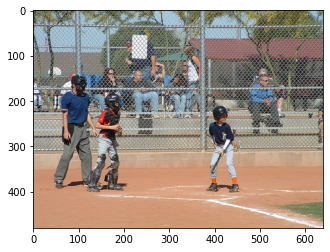

In [ ]:
show_image(idx=11, train=True)

## Pre-Trained Image Model (VGG16)

The following creates an instance of the VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for the image classification.

If `include_top=True` then the whole VGG16 model is downloaded which is about 528 MB. If `include_top=False` then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

We will use some of the fully-connected layers in this pre-trained model, so we have to download the full model, but if you have a slow internet connection, then you can try and modify the code below to use the smaller pre-trained model without the classification layers.

Tutorials #08 and #10 explain more details about Transfer Learning.

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')

553467096/553467096 [==============================] - 3s 0us/step


Print a list of all the layers in the VGG16 model.

In [ ]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We will use the output of the layer prior to the final classification-layer which is named `fc2`. This is a fully-connected (or dense) layer.

In [ ]:
transfer_layer = image_model.get_layer('fc2')

We call it the "transfer-layer" because we will transfer its output to another model that creates the image captions.

To do this, first we need to create a new model which has the same input as the original VGG16 model but outputs the transfer-values from the `fc2` layer.

In [ ]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

The model expects input images to be of this size:

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

For each input image, the new model will output a vector of transfer-values with this length:

In [ ]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Process All Images

We now make functions for processing all images in the data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing the progress.

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

In [ ]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

In [ ]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

Helper-function for processing all images in the validation-set.

In [ ]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

Process all images in the training-set and save the transfer-values to a cache-file. This took about 30 minutes to process on a GTX 1070 GPU.

In [ ]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 5000 images in training-set ...
1/1 [==============================] - 3s 3s/step

- Data saved to cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (5000, 4096)
CPU times: user 56min 55s, sys: 2min 8s, total: 59min 4s
Wall time: 35min 13s


Process all images in the validation-set and save the transfer-values to a cache-file. This took about 90 seconds to process on a GTX 1070 GPU.

In [ ]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 1000 images in validation-set ...
1/1 [==============================] - 3s 3s/step

- Data saved to cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (1000, 4096)
CPU times: user 11min 24s, sys: 26.5 s, total: 11min 51s
Wall time: 6min 57s


## banglaBERT

### downloads and installations

In [ ]:
# install normalizer required for tokenization 
!pip install git+https://github.com/csebuetnlp/normalizer

In [ ]:
!pip install transformers

### imports

In [ ]:
from transformers import ElectraTokenizer, ElectraForPreTraining
from normalizer import normalize
import torch
import numpy as np

### Model Download

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained("csebuetnlp/banglabert")
model = ElectraForPreTraining.from_pretrained("csebuetnlp/banglabert")

#### check

In [ ]:
original_sentence = "আমি কৃতজ্ঞ কারণ আপনি আমার জন্য অনেক কিছু করেছেন।"
fake_sentence = "আমি হতাশ কারণ আপনি আমার জন্য অনেক কিছু করেছেন।"
fake_sentence = normalize(fake_sentence) # this normalization step is required before tokenizing the text
fake_sentence # after normalization

'আমি হতাশ কারণ আপনি আমার জন্য অনেক কিছু করেছেন।'

In [ ]:
fake_inputs = tokenizer.encode(fake_sentence, return_tensors="pt")
fake_inputs.squeeze(0).tolist()

[2, 857, 5938, 1155, 1345, 878, 900, 1011, 916, 1403, 205, 3]

## Tokenizer

Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer. See Tutorial #20 for a more detailed explanation.

Before we can start processing the text, we first need to mark the beginning and end of each text-sequence with unique words that most likely aren't present in the data.

In [ ]:
# mark_start = 'ssss '
# mark_end = ' eeee'

This helper-function wraps all text-strings in the above markers. Note that the captions are a list of list, so we need a nested for-loop to process it. This can be done using so-called list-comprehension in Python.

In [ ]:
# def mark_captions(captions_listlist):
#     captions_marked = [[mark_start + caption + mark_end
#                         for caption in captions_list]
#                         for captions_list in captions_listlist]
    
#     return captions_marked

Now process all the captions in the training-set and show an example.

In [ ]:
# captions_train_marked = mark_captions(captions_train)
# captions_train_marked[0]

['ssss এর স্ক্রিনে একজন ব্যক্তির ছবি সহ একটি স্মার্ট ফোন। eeee',
 'ssss 3টি কম্পিউটার এবং একটি সেল ফোনের একটি স্ট্যাক। eeee',
 'ssss তিনটি ল্যাপটপ কম্পিউটার এবং একটি স্মার্টফোন ধারণকারী একটি স্ট্যাক। eeee',
 'ssss তিনটি ল্যাপটপ একে অপরের উপরে স্তুপীকৃত, বড় থেকে ছোট পর্যন্ত, উপরে একটি সেল ফোন রয়েছে। eeee',
 'ssss একে অপরের উপর তিনটি ইলেকট্রনিক্স স্তুপীকৃত একটি ডেস্ক eeee']

This is how the captions look without the start- and end-markers.

In [ ]:
# captions_train[0]

['এর স্ক্রিনে একজন ব্যক্তির ছবি সহ একটি স্মার্ট ফোন।',
 '3টি কম্পিউটার এবং একটি সেল ফোনের একটি স্ট্যাক।',
 'তিনটি ল্যাপটপ কম্পিউটার এবং একটি স্মার্টফোন ধারণকারী একটি স্ট্যাক।',
 'তিনটি ল্যাপটপ একে অপরের উপরে স্তুপীকৃত, বড় থেকে ছোট পর্যন্ত, উপরে একটি সেল ফোন রয়েছে।',
 'একে অপরের উপর তিনটি ইলেকট্রনিক্স স্তুপীকৃত একটি ডেস্ক']

This helper-function converts a list-of-list to a flattened list of captions.

In [ ]:
# def flatten(captions_listlist):
#     captions_list = [caption
#                      for captions_list in captions_listlist
#                      for caption in captions_list]
    
#     return captions_list

Now use the function to convert all the marked captions from the training set.

In [ ]:
# captions_train_flat = flatten(captions_train_marked)

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 10000 most frequent words in the captions from the training-data.

In [ ]:
# num_words = 10000

We need a few more functions than provided by Keras' Tokenizer-class so we wrap it.

In [ ]:
# class TokenizerWrap(Tokenizer):
#     """Wrap the Tokenizer-class from Keras with more functionality."""
    
#     def __init__(self, texts, num_words=None):
#         """
#         :param texts: List of strings with the data-set.
#         :param num_words: Max number of words to use.
#         """

#         Tokenizer.__init__(self, num_words=num_words)

#         # Create the vocabulary from the texts.
#         self.fit_on_texts(texts)

#         # Create inverse lookup from integer-tokens to words.
#         self.index_to_word = dict(zip(self.word_index.values(),
#                                       self.word_index.keys()))

#     def token_to_word(self, token):
#         """Lookup a single word from an integer-token."""

#         word = " " if token == 0 else self.index_to_word[token]
#         return word 

#     def tokens_to_string(self, tokens):
#         """Convert a list of integer-tokens to a string."""

#         # Create a list of the individual words.
#         words = [self.index_to_word[token]
#                  for token in tokens
#                  if token != 0]
        
#         # Concatenate the words to a single string
#         # with space between all the words.
#         text = " ".join(words)

#         return text
    
#     def captions_to_tokens(self, captions_listlist):
#         """
#         Convert a list-of-list with text-captions to
#         a list-of-list of integer-tokens.
#         """
        
#         # Note that text_to_sequences() takes a list of texts.
#         tokens = [self.texts_to_sequences(captions_list)
#                   for captions_list in captions_listlist]
        
#         return tokens

Now create a tokenizer using all the captions in the training-data. Note that we use the flattened list of captions to create the tokenizer because it cannot take a list-of-lists.

In [ ]:
# %%time
# tokenizer = TokenizerWrap(texts=captions_train_flat,
#                           num_words=num_words)

CPU times: user 366 ms, sys: 4.97 ms, total: 371 ms
Wall time: 372 ms


Get the integer-token for the start-marker (the word "ssss"). We will need this further below.

In [ ]:
# token_start = tokenizer.word_index[mark_start.strip()]
# token_start

2

Get the integer-token for the end-marker (the word "eeee").

In [ ]:
# token_end = tokenizer.word_index[mark_end.strip()]
# token_end

3

Convert all the captions from the training-set to sequences of integer-tokens. We get a list-of-list as a result.

In [ ]:
# %%time
# tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 291 ms, sys: 2.09 ms, total: 293 ms
Wall time: 295 ms


Example of the integer-tokens for the captions of the first image in the training-set:

In [ ]:
# tokens_train[0]

[[2, 257, 1993, 5, 230, 73, 6, 1, 1394, 1347, 3],
 [2, 1994, 100, 4, 1, 176, 636, 1, 4459, 3],
 [2, 131, 95, 100, 4, 1, 3173, 1348, 1, 4459, 3],
 [2, 131, 95, 94, 105, 25, 1349, 20, 51, 16, 1395, 25, 1, 176, 200, 44, 3],
 [2, 94, 105, 23, 131, 1861, 1349, 1, 396, 3]]

These are the corresponding text-captions:

In [ ]:
# captions_train_marked[0]

['ssss এর স্ক্রিনে একজন ব্যক্তির ছবি সহ একটি স্মার্ট ফোন। eeee',
 'ssss 3টি কম্পিউটার এবং একটি সেল ফোনের একটি স্ট্যাক। eeee',
 'ssss তিনটি ল্যাপটপ কম্পিউটার এবং একটি স্মার্টফোন ধারণকারী একটি স্ট্যাক। eeee',
 'ssss তিনটি ল্যাপটপ একে অপরের উপরে স্তুপীকৃত, বড় থেকে ছোট পর্যন্ত, উপরে একটি সেল ফোন রয়েছে। eeee',
 'ssss একে অপরের উপর তিনটি ইলেকট্রনিক্স স্তুপীকৃত একটি ডেস্ক eeee']

## Tokenizer (modified)

In [ ]:
def normalize_and_tokenize_all(captions_listlist):
    captions_list = [[tokenizer.encode(normalize(caption), return_tensors="pt").squeeze(0).tolist()
                     for caption in captions_list]
                     for captions_list in captions_listlist]
    
    return captions_list

In [ ]:
# tokenization
tokens_train = normalize_and_tokenize_all(captions_train)
tokens_train[0]

[[2, 2780, 3604, 815, 5463, 2688, 6274, 788, 4536, 1815, 10775, 205, 3],
 [2,
  2780,
  6536,
  219,
  12184,
  1470,
  6274,
  9556,
  219,
  1361,
  1169,
  913,
  788,
  1808,
  205,
  3],
 [2, 1361, 1169, 792, 3758, 2688, 6274, 1313, 1019, 205, 3],
 [2, 2780, 6536, 903, 25585, 3758, 2688, 6274, 21904, 1019, 205, 3],
 [2, 1313, 1808, 831, 1103, 22522, 6512, 975, 205, 3]]

In [ ]:
# fk
num_words = 10000
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

# len(tokens_train)
max_size = np.max([np.max(tok_list) for tok_list in flatten(tokens_train)])
num_words = max_size + 100
num_words

32078

## Data Generator

Each image in the training-set has at least 5 captions describing the contents of the image. The neural network will be trained with batches of transfer-values for the images and sequences of integer-tokens for the captions. If we were to have matching numpy arrays for the training-set, we would either have to only use a single caption for each image and ignore the rest of this valuable data, or we would have to repeat the image transfer-values for each of the captions, which would waste a lot of memory.

A better solution is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

This helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [ ]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

This generator function creates random batches of training-data for use in training the neural network.

In [ ]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

Set the batch-size used during training. This is set very high so the GPU can be used maximally - but this also requires a lot of RAM on the GPU. You may have to lower this number if the training runs out of memory.

In [ ]:
batch_size = 384

Create an instance of the data-generator.

In [ ]:
generator = batch_generator(batch_size=batch_size)

Test the data-generator by creating a batch of data.

In [ ]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

Example of the transfer-values for the first image in the batch.

In [ ]:
batch_x['transfer_values_input'][0]

array([0.    , 0.    , 1.348 , ..., 0.    , 0.    , 0.5127], dtype=float16)

Example of the token-sequence for the first image in the batch. This is the input to the decoder-part of the neural network.

In [ ]:
batch_x['decoder_input'][0]

array([   2,    5,   13,   14, 2408,   35,    1,  176,  200,   21,    8,
          3,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

This is the token-sequence for the output of the decoder. Note how it is the same as the sequence above, except it is shifted one time-step.

In [ ]:
batch_y['decoder_output'][0]

array([   5,   13,   14, 2408,   35,    1,  176,  200,   21,    8,    3,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

### Steps Per Epoch

One epoch is a complete processing of the training-set. We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an 'epoch' to measure approximately how many iterations of the training-data we have processed. But the data-generator will generate batches for eternity, so we need to manually calculate the approximate number of batches required per epoch.

This is the number of captions for each image in the training-set.

In [ ]:
num_captions_train = [len(captions) for captions in captions_train]

This is the total number of captions in the training-set.

In [ ]:
total_num_captions_train = np.sum(num_captions_train)

This is the approximate number of batches required per epoch, if we want to process each caption and image pair once per epoch.

In [ ]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

65

## Create the Recurrent Neural Network

We will now create the Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be converted into text. We call this neural network for the 'decoder' as it is almost identical to the decoder when doing Machine Translation in Tutorial #21.

Note that we are using the functional model from Keras to build this neural network, because it allows more flexibility in how the neural network can be connected, in case you want to experiment and connect the image-model directly to the decoder (see the exercises). This means we have split the network construction into two parts: (1) Creation of all the layers that are not yet connected, and (2) a function that connects all these layers.

The decoder consists of 3 GRU layers whose internal state-sizes are:

In [ ]:
state_size = 512

The embedding-layer converts integer-tokens into vectors of this length:

In [ ]:
embedding_size = 128

This inputs transfer-values to the decoder:

In [ ]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

We want to use the transfer-values to initialize the internal states of the GRU units. This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512, so we use a fully-connected layer to map the vectors from 4096 to 512 elements.

Note that we use a `tanh` activation function to limit the output of the mapping between -1 and 1, otherwise this does not seem to work.

In [ ]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

This is the input for token-sequences to the decoder. Using `None` in the shape means that the token-sequences can have arbitrary lengths.

In [ ]:
decoder_input = Input(shape=(None, ), name='decoder_input')

This is the embedding-layer which converts sequences of integer-tokens to sequences of vectors.

In [ ]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [ ]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output a tensor with shape `[batch_size, sequence_length, state_size]`, where each "word" is encoded as a vector of length `state_size`. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

One way of doing this is to convert the GRU output to a one-hot encoded array. It works but it is extremely wasteful, because for a vocabulary of e.g. 10000 words we need a vector with 10000 elements, so we can select the index of the highest element to be the integer-token.

In [ ]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

### Connect and Create the Training Model

The decoder is built using the functional API of Keras, which allows more flexibility in connecting the layers e.g. to have multiple inputs. This is useful e.g. if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values.

This function connects all the layers of the decoder to some input of transfer-values.

In [ ]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

Connect and create the model used for training. This takes as input transfer-values and sequences of integer-tokens and outputs sequences of one-hot encoded arrays that can be converted into integer-tokens.

In [ ]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Compile the Model

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in the `batch_generator()` above.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays.

We have used the Adam optimizer in many of the previous tutorials, but it seems to diverge in some of these experiments with Recurrent Neural Networks. RMSprop seems to work much better for these.

In [ ]:
decoder_model.compile(optimizer=RMSprop(learning_rate=1e-3),
                      loss='sparse_categorical_crossentropy')

### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

This is the callback for writing the TensorBoard log during training.

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

You can reload the last saved checkpoint so you don't have to train the model every time you want to use it.

In [ ]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = '22_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Train the Model

Now we will train the decoder so it can map transfer-values from the image-model to sequences of integer-tokens for the captions of the images.

One epoch of training took about 7 minutes on a GTX 1070 GPU. You probably need to run 20 epochs or more during training.

Note that if we didn't use pre-computed transfer-values then each epoch would take maybe 40 minutes to run, because all the images would have to be processed by the VGG16 model as well.

In [ ]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=20,
                  callbacks=callbacks)

Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 3.4170
Epoch 1: saving model to 22_checkpoint.keras
65/65 [==============================] - 478s 7s/step - loss: 3.4170
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 2.7406
Epoch 2: saving model to 22_checkpoint.keras
65/65 [==============================] - 495s 8s/step - loss: 2.7406
Epoch 3/20
65/65 [==============================] - ETA: 0s - loss: 2.7024
Epoch 3: saving model to 22_checkpoint.keras
65/65 [==============================] - 484s 7s/step - loss: 2.7024
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 2.4576
Epoch 4: saving model to 22_checkpoint.keras
65/65 [==============================] - 510s 8s/step - loss: 2.4576
Epoch 5/20
65/65 [==============================] - ETA: 0s - loss: 2.4584
Epoch 5: saving model to 22_checkpoint.keras
65/65 [==============================] - 497s 8s/step - loss: 2.4584
Epoch 6/20
65/65 [==============================] - ETA

## Generate Captions

This function loads an image and generates a caption using the model we have trained.

In [ ]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

### Examples

Try this with a picture of a parrot.

1/1 [==============================] - 0s 47ms/step


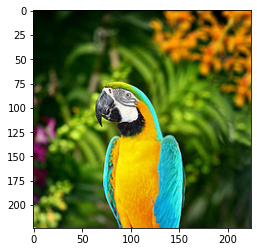

Predicted caption:
 একটি মেরু ভালুক একটি গাছের উপর দাঁড়িয়ে আছে। eeee



In [ ]:
generate_caption("images/parrot_cropped1.jpg")

1/1 [==============================] - 0s 49ms/step


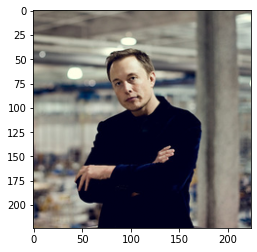

Predicted caption:
 একটি ছোট মেয়ে একটি ছোট কুকুর একটি ফ্রিসবি ধরে আছে। eeee



In [ ]:
generate_caption("images/elon_musk.jpg")

Helper-function for loading an image from the COCO data-set and printing the true captions as well as the predicted caption.

In [ ]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

1/1 [==============================] - 0s 65ms/step


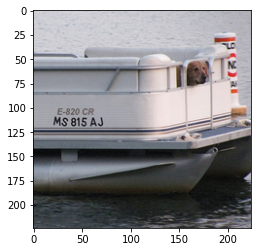

Predicted caption:
 একটি ছোট বিমান একটি নীল এবং সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা সাদা

True captions:
একটি কুকুর সাদা নৌকার ভিতরে বসে আছে।
একটি কুকুর জলে ভাসমান একটি নৌকায় বসে
কুকুর অলসভাবে একটি জোড়া-হুলড নৌকার পিছনে তাকিয়ে আছে।
পানিতে নৌকায় চড়ে বেড়াচ্ছে কুকুরটি।
একটি সাদা নৌকা জলের উপর আছে


In [ ]:
generate_caption_coco(idx=1, train=True)

1/1 [==============================] - 0s 47ms/step


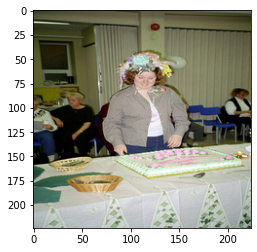

Predicted caption:
 একজন লোক একটি ছোট ছেলে একটি wii গেম গেম খেলছে। eeee

True captions:
টেবিলের উপরে বসে থাকা একটি শীট কেকের উপর দাঁড়িয়ে থাকা একজন মহিলা।
একজন ভদ্রমহিলা একটি উদযাপন করছেন এবং তার কেকের দিকে তাকাচ্ছেন
টুপি পরা একজন ভদ্রমহিলা একটি বড় কেকের সামনে দাঁড়িয়ে আছেন।
টুপি পরা একজন নারী কেকের দিকে তাকিয়ে আছেন।
একটি নির্বোধ টুপি পরা একজন মহিলা কেক কাটছেন৷


In [ ]:
generate_caption_coco(idx=10, train=True)

1/1 [==============================] - 0s 52ms/step


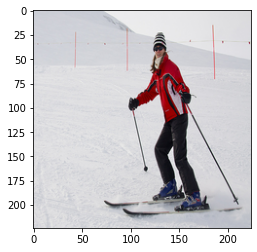

Predicted caption:
 একজন ব্যক্তি একটি ফ্রিসবি ধরে জন্য একটি ফ্রিসবি ধরে আছে। eeee

True captions:
একজন মহিলা স্কিসে দাঁড়িয়ে ক্যামেরার জন্য পোজ দিচ্ছেন।
ক্যামেরার জন্য পোজ দেওয়ার সময় স্কিসে দাঁড়িয়ে থাকা একজন মহিলা৷
লাল জ্যাকেট পরা একজন মহিলা ঢাল বেয়ে স্কিইং করছেন
এক তরুণী পাহাড়ের ঢালে স্কিইং করছেন।
স্কিসের একজন ব্যক্তি বরফের মধ্য দিয়ে তার পথ তৈরি করে


In [ ]:
generate_caption_coco(idx=1, train=False)